In [1]:
import pandas as pd                     # pandas library for data manipulation and analysis
import matplotlib.pyplot as plt         # matplotlib library for data visualization
import tensorflow as tf                 # TensorFlow library for machine learning
from tensorflow import keras            # Keras module from TensorFlow for building neural networks

2023-07-06 09:05:34.521110: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv("/Users/billtsios/weather.csv")

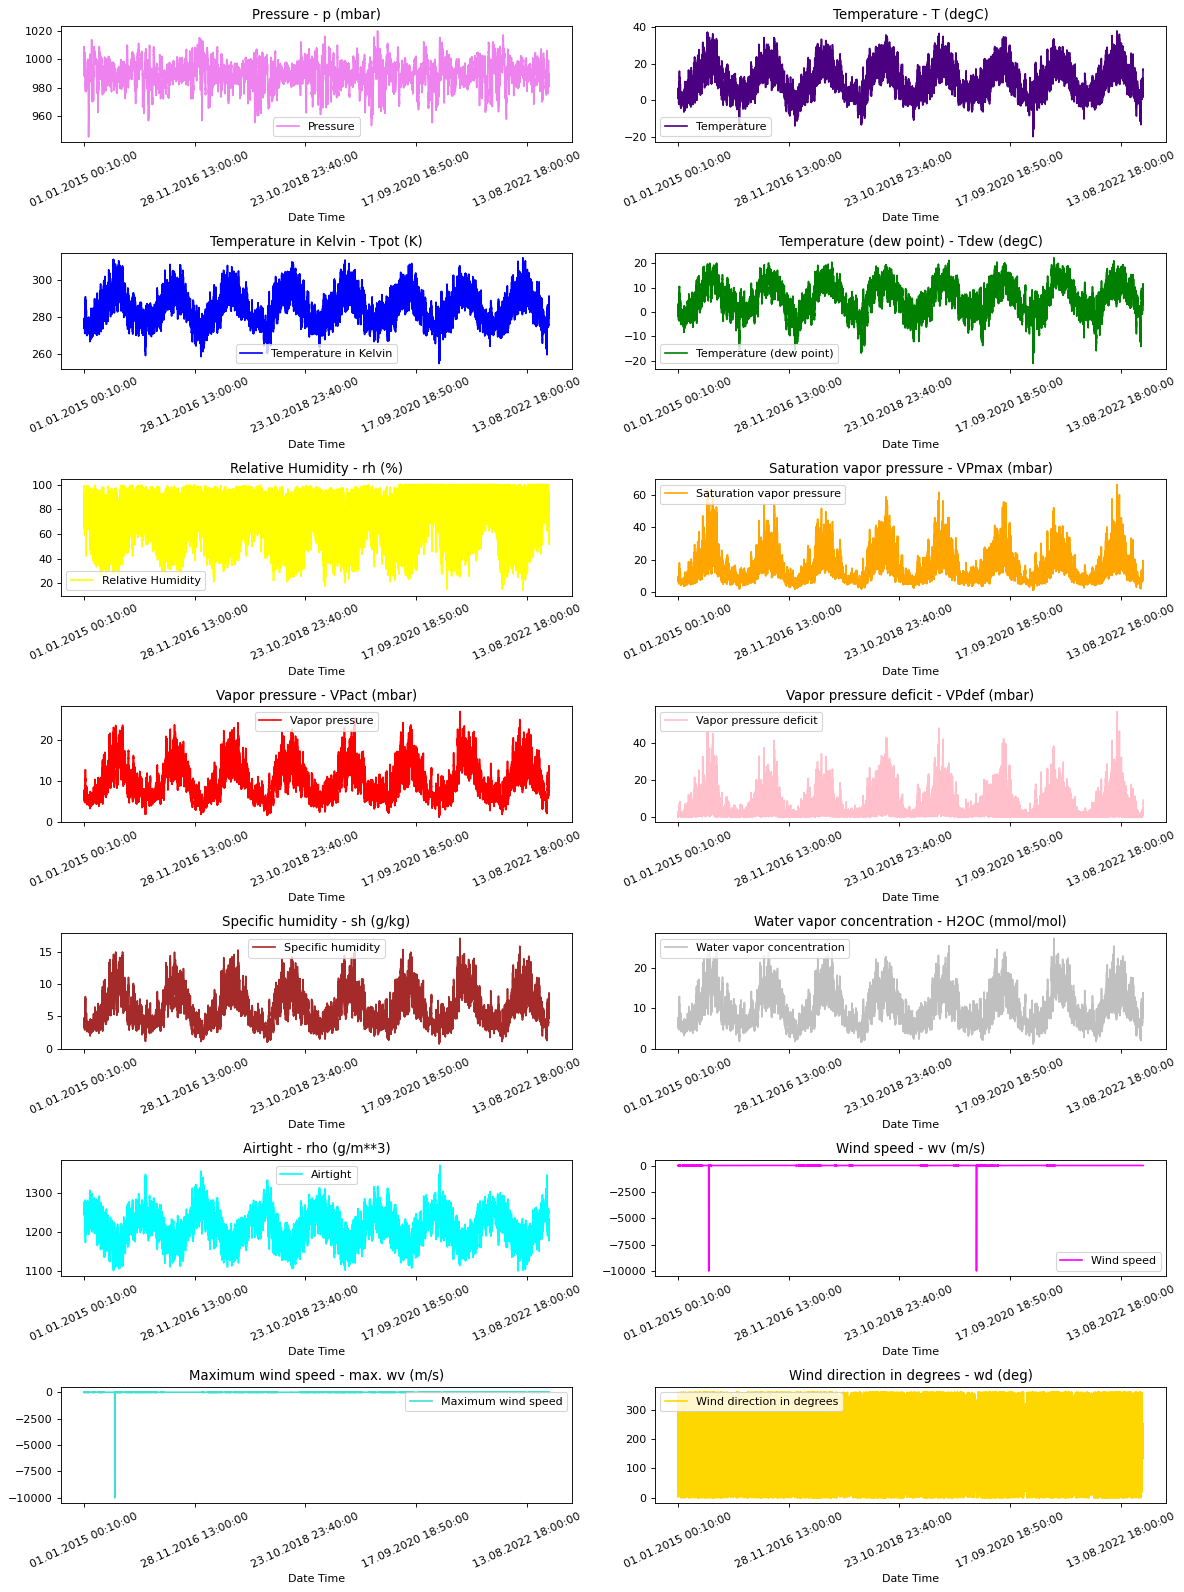

In [3]:
# Raw data visualization
# List of titles for each feature
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

# List of feature keys corresponding to the titles
feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

# List of colors for visualization
colors = [
    "violet",
    "indigo",
    "blue",
    "green",
    "yellow",
    "orange",
    "red",
    "pink",
    "brown",
    "silver",
    "cyan",
    "magenta",
    "turquoise",
    "gold",
    "gray"
]

# Key for the date and time column
date_time_key = "Date Time"

# Function to display raw visualization of data
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()

# Call the function to display the raw visualization
show_raw_visualization(df)

/var/folders/kr/6b34m3v54ns46m3w3w86gxjc0000gn/T/ipykernel_5819/3897922630.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(data.corr())


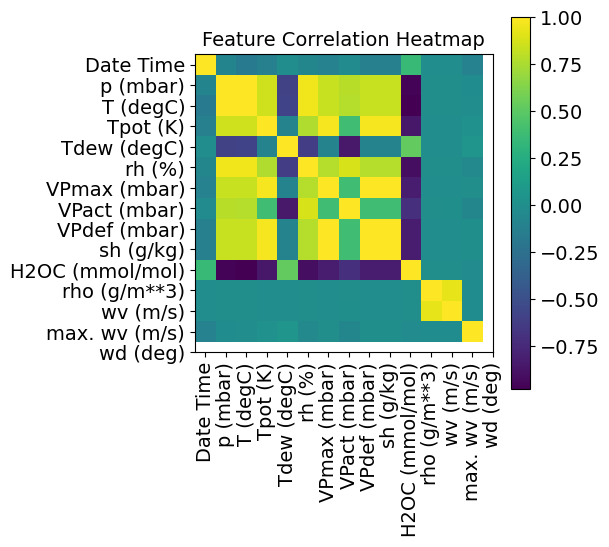

In [4]:
def show_heatmap(data):
    # Display a correlation matrix heatmap using matshow
    plt.matshow(data.corr())
    
    # Set x-axis tick labels to column names and rotate them by 90 degrees
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    
    # Move the x-axis ticks to the bottom
    plt.gca().xaxis.tick_bottom()
    
    # Set y-axis tick labels to column names
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    # Add a colorbar to indicate the correlation values
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    
    # Set the title of the heatmap
    plt.title("Feature Correlation Heatmap", fontsize=14)
    
    # Display the heatmap
    plt.show()


# Call the function to show the heatmap for the DataFrame 'df'
show_heatmap(df)


In [5]:
# Data preprocessing
split_fraction = 0.715                             # Fraction of data to be used for training
train_split = int(split_fraction * int(df.shape[0]))   # Number of samples for training
step = 6                                           # Step size for creating sequences

past = 720                                         # Number of past time steps to consider
future = 72                                        # Number of future time steps to predict
learning_rate = 0.001                              # Learning rate for the model
batch_size = 256                                   # Batch size for training
epochs = 10                                        # Number of epochs for training

def normalize(data, train_split):
    # Calculate the mean and standard deviation of the training data
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    
    # Normalize the data by subtracting the mean and dividing by the standard deviation
    return (data - data_mean) / data_std


In [8]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)

# Create a list of selected feature keys based on their indices
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]

# Select the columns corresponding to the selected features from the DataFrame
features = df[selected_features]

# Set the index of the features DataFrame to the date-time column
features.index = df[date_time_key]

# Display the first few rows of the features DataFrame
features.head()

# Normalize the features data using the normalize function
features = normalize(features.values, train_split)

# Convert the normalized features data back to a DataFrame
features = pd.DataFrame(features)

# Display the first few rows of the normalized features DataFrame
features.head()

# Split the normalized features data into training and validation datasets
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]


The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [9]:
# Training dataset
start = past + future                               # Starting index for training data
end = start + train_split                           # Ending index for training data

# Extract the input features for training (columns 0 to 6)
x_train = train_data[[i for i in range(7)]].values

# Extract the target variable for training (column 1)
y_train = features.iloc[start:end][[1]]

# Calculate the sequence length based on the number of past time steps and the step size
sequence_length = int(past / step)


In [10]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,                                           # Input features for training
    y_train,                                           # Target variable for training
    sequence_length=sequence_length,                   # Length of each sequence
    sampling_rate=step,                                # Step size between time steps
    batch_size=batch_size,                             # Batch size for training
)

In [11]:
# Validation dataset
x_end = len(val_data) - past - future                     # Ending index for validation data

label_start = train_split + past + future                 # Starting index for target variable in validation data

# Extract the input features for validation (columns 0 to 6)
x_val = val_data.iloc[:x_end][[i for i in range(7)]].values

# Extract the target variable for validation (column 1)
y_val = features.iloc[label_start:][[1]]

# Create a time series dataset for validation
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

# Print the shapes of inputs and targets for the first batch in the training dataset
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)


Input shape: (256, 120, 7)
Target shape: (256, 1)


2023-07-06 09:06:34.850762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [300440,7]
	 [[{{node Placeholder/_0}}]]
2023-07-06 09:06:34.851556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [300440,1]
	 [[{{node Placeholder/_20}}]]


In [34]:
# Training
# Increased model complexity but not overfitted
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))   # Define the input layer with appropriate shape
lstm_out = keras.layers.LSTM(64, return_sequences=True)(inputs)        # Add the first LSTM layer with 64 units and return sequences
lstm_out = keras.layers.LSTM(64)(lstm_out)                             # Add the second LSTM layer with 64 units
outputs = keras.layers.Dense(1)(lstm_out)                              # Add a dense output layer with 1 unit

# Create the model with input and output layers
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and mean squared error loss
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

# Print the summary of the model
model.summary()


2023-07-06 10:26:39.494083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-06 10:26:39.495107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-06 10:26:39.496514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 120, 64)           18432     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 51,521
Trainable params: 51,521
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Define early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)


In [35]:
path_checkpoint = "model_checkpoint.h5"                       # File path for saving the model checkpoint
es_callback = keras.callbacks.EarlyStopping(                   # Early stopping callback
    monitor="val_loss",                                        # Monitor the validation loss for early stopping
    min_delta=0,                                                # Minimum change in validation loss to be considered an improvement
    patience=5                                                  # Number of epochs with no improvement after which training will be stopped
)

modelckpt_callback = keras.callbacks.ModelCheckpoint(          # Model checkpoint callback
    monitor="val_loss",                                         # Monitor the validation loss for saving the best model
    filepath=path_checkpoint,                                   # File path for saving the best model checkpoint
    verbose=1,                                                  # Verbosity mode (1 for displaying messages)
    save_weights_only=True,                                     # Save only the weights, not the entire model
    save_best_only=True                                         # Save only the best model based on validation loss
)

history = model.fit(                                           # Train the model
    dataset_train,                                             # Training dataset
    epochs=epochs,                                             # Number of epochs to train
    validation_data=dataset_val,                               # Validation dataset
    callbacks=[es_callback, modelckpt_callback],               # Callbacks for early stopping and model checkpoint
)


Epoch 1/10


2023-07-06 10:26:43.606668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-06 10:26:43.608416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-06 10:26:43.609656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1171/1171 [==============================] - ETA: 0s - loss: 0.1643

2023-07-06 10:31:42.674902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-06 10:31:42.675911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-06 10:31:42.677173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1171/1171 [==============================] - 347s 294ms/step - loss: 0.1643 - val_loss: 0.2660
Epoch 2/10
1171/1171 [==============================] - 341s 291ms/step - loss: 0.1457 - val_loss: 0.2162
Epoch 3/10
1171/1171 [==============================] - 347s 296ms/step - loss: 0.1388 - val_loss: 0.2129
Epoch 4/10
1171/1171 [==============================] - 336s 287ms/step - loss: 0.1317 - val_loss: 0.2030
Epoch 5/10
1171/1171 [==============================] - 343s 293ms/step - loss: 0.1282 - val_loss: 0.1957
Epoch 6/10
1171/1171 [==============================] - 347s 297ms/step - loss: 0.1250 - val_loss: 0.1914
Epoch 7/10
1171/1171 [==============================] - 346s 296ms/step - loss: 0.1217 - val_loss: 0.1880
Epoch 8/10
1171/1171 [==============================] - 353s 302ms/step - loss: 0.1198 - val_loss: 0.1936
Epoch 9/10
1171/1171 [==============================] - 349s 298ms/step - loss: 0.1176 - val_loss: 0.1797
Epoch 10/10
1171/1171 [==============================] - 

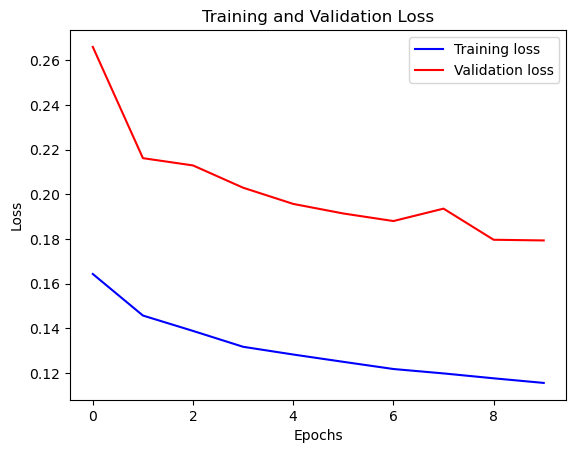

In [36]:
def visualize_loss(history, title):
    loss = history.history["loss"]                         # Training loss values
    val_loss = history.history["val_loss"]                 # Validation loss values
    epochs = range(len(loss))                              # Number of epochs
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")     # Plot training loss
    plt.plot(epochs, val_loss, "r", label="Validation loss")   # Plot validation loss
    plt.title(title)                                       # Set the title of the plot
    plt.xlabel("Epochs")                                   # Label for x-axis
    plt.ylabel("Loss")                                     # Label for y-axis
    plt.legend()                                           # Show legend
    plt.show()


# Call the function to visualize the training and validation loss
visualize_loss(history, "Training and Validation Loss")


2023-07-06 11:24:36.445930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [118965,7]
	 [[{{node Placeholder/_0}}]]
2023-07-06 11:24:36.447038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-06 11:24:36.735055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype i

8/8 [==============================] - 1s 25ms/step


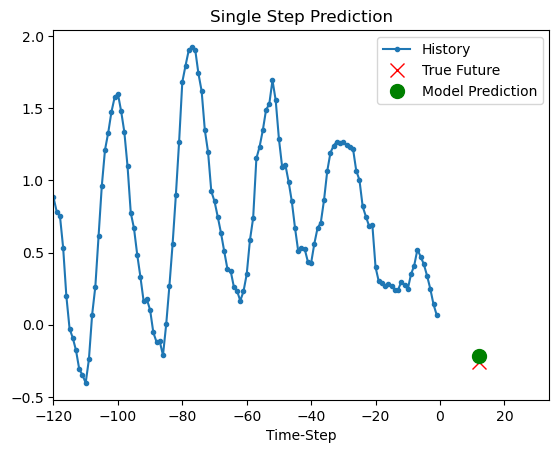

8/8 [==============================] - 0s 19ms/step


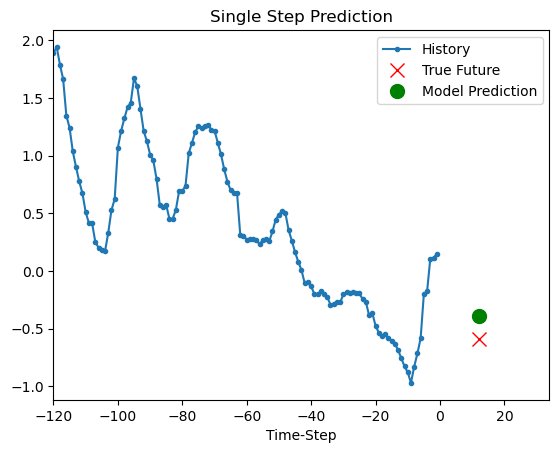

8/8 [==============================] - 0s 20ms/step


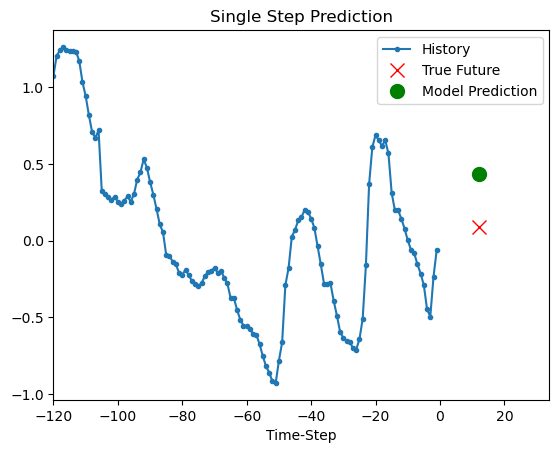

8/8 [==============================] - 0s 29ms/step


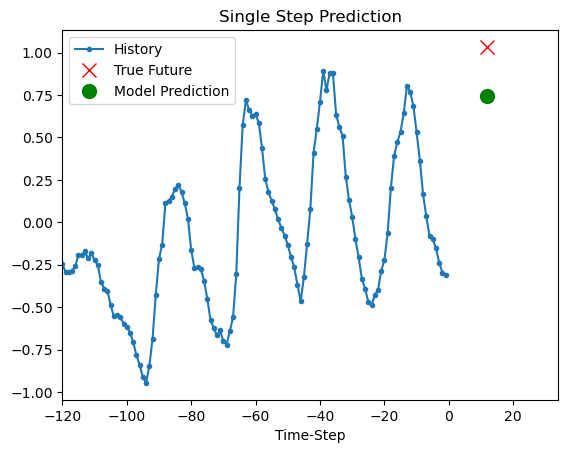

8/8 [==============================] - 0s 19ms/step


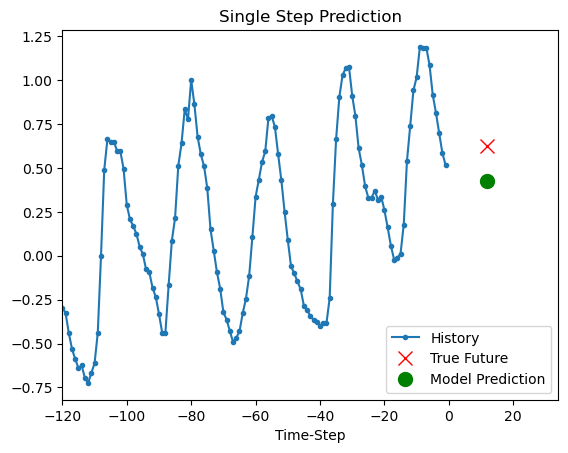

In [37]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]        # Labels for the plot data
    marker = [".-", "rx", "go"]                                   # Marker styles for the plot
    time_steps = list(range(-(plot_data[0].shape[0]), 0))          # Time steps for the history data
    if delta:
        future = delta                                             
    else:
        future = 0                                                  # Number of future time steps to predict

    plt.title(title)                                              # Set the title of the plot
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])   # Plot true future and model prediction
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])    # Plot history data
    plt.legend()                                                  # Show legend
    plt.xlim([time_steps[0], (future + 5) * 2])                    # Set x-axis limits
    plt.xlabel("Time-Step")                                        # Label for x-axis
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],    # Plot history, true future, and model prediction
        12,                                                         # Number of future time steps to predict
        "Single Step Prediction"                                    # Title of the plot
    )
